In [39]:
import glob
from collections import deque
import numpy as np
import tensorflow as tf
import torch
import torch.nn as nn
from torch.utils.data import IterableDataset, DataLoader
from tqdm import tqdm
import math
import matplotlib.pyplot as plt


## Data Processing

In [ ]:
class AudioFrameTFRecordDataset(IterableDataset):
    def __init__(self, pattern, seq_len, mode="regression"):
        self.files = sorted(glob.glob(pattern))
        self.seq_len = seq_len
        assert mode in ("regression","classification")
        self.mode = mode

        self.seq_feat = {
            "audio": tf.io.FixedLenSequenceFeature([], tf.string)
        }

    def __iter__(self):
        for fn in self.files:
            ds = tf.data.TFRecordDataset(fn)
            for raw in ds:
                _, seq_dict = tf.io.parse_single_sequence_example(
                    raw,
                    context_features={},
                    sequence_features=self.seq_feat
                )
                audio_raw = seq_dict["audio"].numpy()

                for idx in range(self.seq_len, len(audio_raw)):
                    window_bytes = audio_raw[idx-self.seq_len : idx]
                    seq_np = np.stack([
                        np.frombuffer(b, dtype=np.uint8).astype(np.float32) / 255.0
                        for b in window_bytes
                    ], axis=0)
                    seq = torch.from_numpy(seq_np)

                    target_bytes = audio_raw[idx]
                    if self.mode == "regression":
                        targ_np = (np.frombuffer(target_bytes, dtype=np.uint8)
                                    .astype(np.float32) / 255.0)
                        target = torch.from_numpy(targ_np).float()
                    else:
                        targ_np = np.frombuffer(target_bytes, dtype=np.uint8)
                        target = torch.from_numpy(targ_np).long()

                    yield seq, target


In [ ]:
# DataLoader

SEQ_LEN = 5
BATCH_SZ = 32

reg_dataset = AudioFrameTFRecordDataset("train/*.tfrecord", SEQ_LEN, mode="regression")
reg_loader = DataLoader(reg_dataset, batch_size=BATCH_SZ)

reg_val_ds = AudioFrameTFRecordDataset(pattern="val/*.tfrecord", seq_len=SEQ_LEN, mode="regression")
reg_val_loader = DataLoader(reg_val_ds, batch_size=BATCH_SZ)


## Regressor

In [ ]:
# LSTM Regressor

class AudioRNN(torch.nn.Module):
    def __init__(self, input_dim=128, hidden_dim=256, num_layers=2):
        super().__init__()
        self.lstm = torch.nn.LSTM(
            input_dim, hidden_dim,
            num_layers, batch_first=True
        )
        self.fc = torch.nn.Linear(hidden_dim, input_dim)

    def forward(self, x):
        out, _ = self.lstm(x)
        last   = out[:, -1, :]
        return self.fc(last)


In [24]:
# Loss

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = AudioRNN(input_dim=128, hidden_dim=256, num_layers=2)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = torch.nn.MSELoss()


In [ ]:
# Training

NUM_EPOCHS = 5

seq_feat = {"audio": tf.io.FixedLenSequenceFeature([], tf.string)}

def count_windows(pattern, seq_len):
    total = 0
    for fn in sorted(glob.glob(pattern)):
        for raw in tf.data.TFRecordDataset(fn):
            _, seq_dict = tf.io.parse_single_sequence_example(
                raw, {}, sequence_features=seq_feat
            )
            T = seq_dict["audio"].shape[0]
            total += max(T - seq_len, 0)
    return total

total_windows = count_windows("train/*.tfrecord", SEQ_LEN)
total_batches = math.ceil(total_windows / BATCH_SZ)

val_windows = count_windows("val/*.tfrecord", SEQ_LEN)
val_batches = math.ceil(val_windows / BATCH_SZ)

# Training + Validation Loop

for epoch in range(1, NUM_EPOCHS+1):
    # Training
    model.train()
    train_loss = 0.0

    pbar = tqdm(reg_loader, desc=f"Epoch {epoch}/{NUM_EPOCHS} Train", unit="batch")
    for batch_idx, (seqs, targets) in enumerate(pbar, start=1):
        seqs, targets = seqs.to(device), targets.to(device)

        optimizer.zero_grad()
        preds = model(seqs)
        loss = criterion(preds, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        pbar.set_postfix({"loss": f"{loss.item():.2e}"})
    pbar.close()

    avg_train_loss = train_loss / total_batches
    print(f"→ Epoch {epoch} Train MSE: {avg_train_loss:.6f}")

    # Validation
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        vbar = tqdm(reg_val_loader, desc=f"Epoch {epoch}/{NUM_EPOCHS} Val",unit="batch")
        for seqs, targets in vbar:
            seqs, targets = seqs.to(device), targets.to(device)
            preds = model(seqs)
            loss = criterion(preds, targets)
            val_loss += loss.item()
            vbar.set_postfix({"v_loss": f"{loss.item():.2e}"})
        vbar.close()

    avg_val_loss = val_loss / val_batches
    print(f"→ Epoch {epoch} Val MSE: {avg_val_loss:.6f}\n")

Epoch 1/5 Train: 113731batch [17:07, 110.70batch/s, loss=5.67e-02]


→ Epoch 1 Train MSE: 0.056393


Epoch 1/5 Val: 27826batch [02:08, 216.03batch/s, v_loss=2.60e-02]


→ Epoch 1   Val MSE: 0.059111



Epoch 2/5 Train: 113731batch [18:40, 101.52batch/s, loss=5.66e-02]


→ Epoch 2 Train MSE: 0.055921


Epoch 2/5 Val: 27826batch [02:43, 170.02batch/s, v_loss=2.62e-02]


→ Epoch 2   Val MSE: 0.058749



Epoch 3/5 Train: 113731batch [17:58, 105.46batch/s, loss=5.65e-02]


→ Epoch 3 Train MSE: 0.055604


Epoch 3/5 Val: 27826batch [02:07, 218.52batch/s, v_loss=2.61e-02]


→ Epoch 3   Val MSE: 0.058520



Epoch 4/5 Train: 113731batch [18:39, 101.60batch/s, loss=5.64e-02]


→ Epoch 4 Train MSE: 0.055409


Epoch 4/5 Val: 27826batch [02:31, 184.11batch/s, v_loss=2.59e-02]


→ Epoch 4   Val MSE: 0.058354



Epoch 5/5 Train: 113731batch [18:28, 102.63batch/s, loss=5.62e-02]


→ Epoch 5 Train MSE: 0.055267


Epoch 5/5 Val: 27826batch [02:08, 217.13batch/s, v_loss=2.57e-02]


→ Epoch 5   Val MSE: 0.058199



## Classifier

In [30]:
# Classification

class AudioClassifierRNN(nn.Module):
    def __init__(self, input_dim=128, hidden_dim=256, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 128 * 256)

    def forward(self, x):
        out, _ = self.lstm(x)
        last = out[:, -1, :]
        logits = self.fc(last)
        return logits.view(x.size(0), 128, 256)


In [34]:
# Loss + optimizer + perplexity

clf_model = AudioClassifierRNN().to(device)
optimizer = torch.optim.Adam(clf_model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

def compute_metrics(logits, targets):
    B = logits.size(0)
    flat_logits = logits.view(-1, 256)
    flat_targ = targets.view(-1)
    loss = criterion(flat_logits, flat_targ)

    pred = flat_logits.argmax(dim=1)
    correct = (pred == flat_targ).float().mean().item()

    ppl = torch.exp(loss).item()
    return loss, correct, ppl


In [35]:
# Data loader

clf_dataset = AudioFrameTFRecordDataset("train/*.tfrecord", SEQ_LEN, mode="classification")
clf_loader = DataLoader(clf_dataset, batch_size=BATCH_SZ)

clf_val_ds = AudioFrameTFRecordDataset("val/*.tfrecord", SEQ_LEN, mode="classification")
clf_val_loader = DataLoader(clf_val_ds, batch_size=BATCH_SZ)

In [ ]:
# Training loop

EPOCHS = 5

for epoch in range(1, EPOCHS+1):
    # Train
    clf_model.train()
    running_loss = running_acc = running_ppl = 0.0

    train_bar = tqdm(clf_loader, desc=f"Epoch {epoch}/{EPOCHS} Train", unit="batch")
    for batch_idx, (seqs, targets) in enumerate(train_bar, start=1):
        seqs, targets = seqs.to(device), targets.to(device)

        optimizer.zero_grad()
        logits = clf_model(seqs)
        loss, acc, ppl = compute_metrics(logits, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_acc += acc
        running_ppl += ppl

        train_bar.set_postfix({"loss": f"{loss.item():.2e}", "acc": f"{acc:.3f}", "ppl": f"{ppl:.1f}"})
    train_bar.close()

    n_train = batch_idx
    print(f"→ Epoch {epoch} Train avg loss={running_loss/n_train:.4f}, "
          f"acc={running_acc/n_train:.3f}, ppl={running_ppl/n_train:.1f}")

    # Validation
    clf_model.eval()
    val_loss = val_acc = val_ppl = 0.0

    with torch.no_grad():
        val_bar = tqdm(clf_val_loader, desc=f"Epoch {epoch}/{EPOCHS} Val", unit="batch")
        for batch_idx, (seqs, targets) in enumerate(val_bar, start=1):
            seqs, targets = seqs.to(device), targets.to(device)
            logits = clf_model(seqs)
            loss, acc, ppl = compute_metrics(logits, targets)

            val_loss += loss.item()
            val_acc += acc
            val_ppl += ppl

            val_bar.set_postfix({"loss": f"{loss.item():.2e}", "acc": f"{acc:.3f}", "ppl": f"{ppl:.1f}"})
        val_bar.close()

    n_val = batch_idx
    print(f"→ Epoch {epoch} Val avg loss={val_loss/n_val:.4f}, "
          f"acc={val_acc/n_val:.3f}, ppl={val_ppl/n_val:.1f}\n")


Epoch 1/5  Train: 113731batch [41:59, 45.14batch/s, loss=5.25e+00, acc=0.059, ppl=190.7]


→ Epoch 1 Train avg loss=4.9282, acc=0.117, ppl=155.6


Epoch 1/5    Val: 27826batch [03:12, 144.59batch/s, loss=5.13e+00, acc=0.037, ppl=169.4] 


→ Epoch 1   Val   avg loss=4.8393, acc=0.136, ppl=145.4



Epoch 2/5  Train: 113731batch [42:17, 44.82batch/s, loss=5.26e+00, acc=0.047, ppl=191.8]


→ Epoch 2 Train avg loss=4.8095, acc=0.144, ppl=138.8


Epoch 2/5    Val: 27826batch [03:13, 143.67batch/s, loss=5.05e+00, acc=0.039, ppl=156.5]


→ Epoch 2   Val   avg loss=4.7712, acc=0.152, ppl=135.7



Epoch 3/5  Train: 113731batch [54:57, 34.49batch/s, loss=5.24e+00, acc=0.047, ppl=187.9]


→ Epoch 3 Train avg loss=4.7631, acc=0.153, ppl=132.8


Epoch 3/5    Val: 27826batch [03:27, 134.28batch/s, loss=5.00e+00, acc=0.038, ppl=149.1]


→ Epoch 3   Val   avg loss=4.7460, acc=0.157, ppl=132.5



Epoch 4/5  Train: 113731batch [59:35, 31.81batch/s, loss=5.24e+00, acc=0.045, ppl=187.8]


→ Epoch 4 Train avg loss=4.7407, acc=0.158, ppl=130.1


Epoch 4/5    Val: 27826batch [03:49, 121.19batch/s, loss=4.98e+00, acc=0.039, ppl=145.0]


→ Epoch 4   Val   avg loss=4.7340, acc=0.160, ppl=131.2



Epoch 5/5  Train: 113731batch [47:53, 39.58batch/s, loss=5.23e+00, acc=0.055, ppl=186.7]


→ Epoch 5 Train avg loss=4.7276, acc=0.160, ppl=128.6


Epoch 5/5    Val: 27826batch [03:18, 140.48batch/s, loss=4.96e+00, acc=0.041, ppl=142.0]

→ Epoch 5   Val   avg loss=4.7266, acc=0.162, ppl=130.2



## Visualization

In [ ]:
reg_train_mse = [0.056393, 0.055921, 0.055604, 0.055409, 0.055267]
reg_val_mse = [0.059111, 0.058749, 0.058520, 0.058354, 0.058199]

clf_train_loss = [4.9282, 4.8095, 4.7631, 4.7407, 4.7276]
clf_val_loss = [4.8393, 4.7712, 4.7460, 4.7340, 4.7266]
clf_train_acc = [0.117, 0.144, 0.153, 0.158, 0.160]
clf_val_acc = [0.136, 0.152, 0.157, 0.160, 0.162]
clf_train_ppl = [155.6, 138.8, 132.8, 130.1, 128.6]
clf_val_ppl = [145.4, 135.7, 132.5, 131.2, 130.2]

epochs_reg = list(range(1, len(reg_train_mse) + 1))
epochs_clf = list(range(1, len(clf_train_loss) + 1))

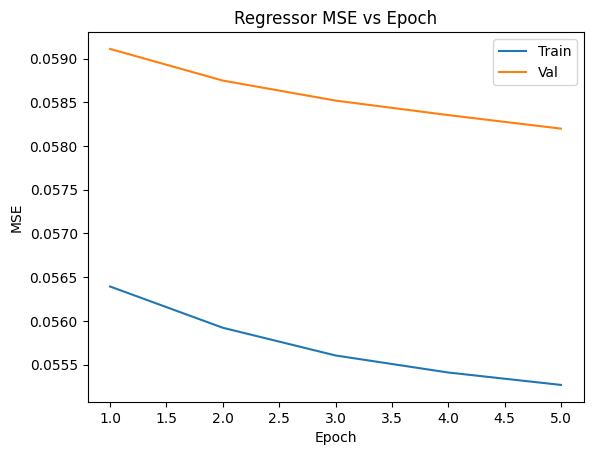

In [40]:
plt.figure()
plt.plot(epochs_reg, reg_train_mse)
plt.plot(epochs_reg, reg_val_mse)
plt.title("Regressor MSE vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend(["Train", "Val"])
plt.show()

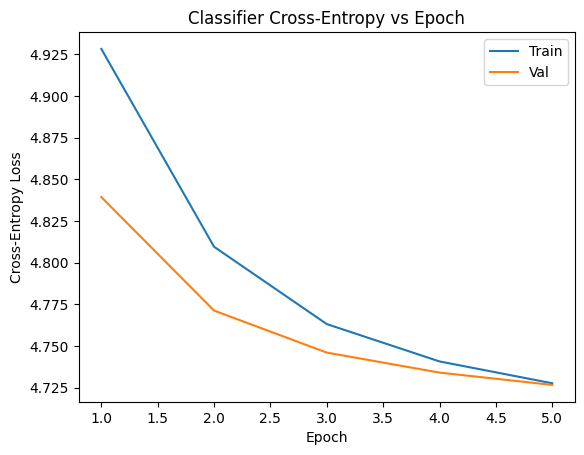

In [41]:
plt.figure()
plt.plot(epochs_clf, clf_train_loss)
plt.plot(epochs_clf, clf_val_loss)
plt.title("Classifier Cross-Entropy vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Cross-Entropy Loss")
plt.legend(["Train", "Val"])
plt.show()

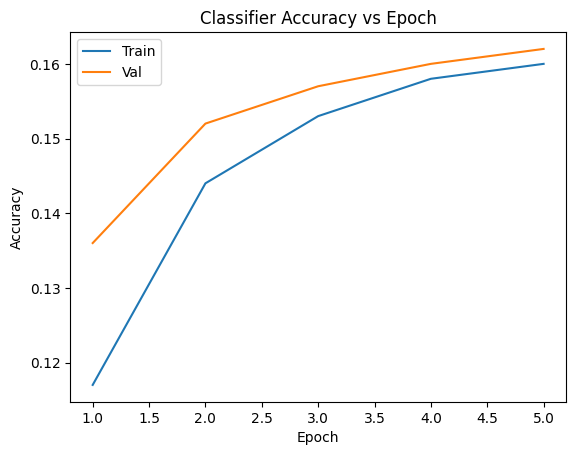

In [42]:
plt.figure()
plt.plot(epochs_clf, clf_train_acc)
plt.plot(epochs_clf, clf_val_acc)
plt.title("Classifier Accuracy vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Train", "Val"])
plt.show()

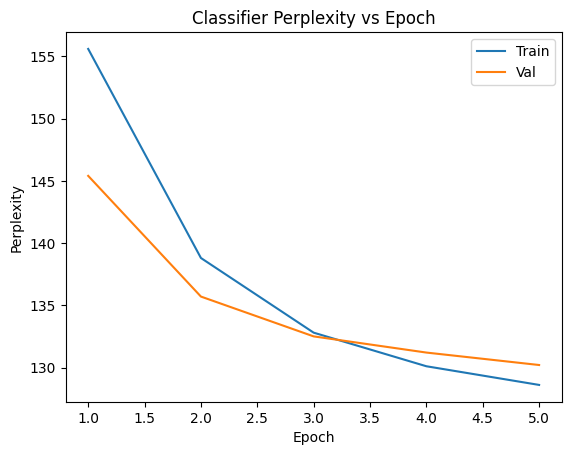

In [43]:
plt.figure()
plt.plot(epochs_clf, clf_train_ppl)
plt.plot(epochs_clf, clf_val_ppl)
plt.title("Classifier Perplexity vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Perplexity")
plt.legend(["Train", "Val"])
plt.show()